# Introduction

We'll explore the use of [pymc3](https://github.com/pymc-devs/pymc3) and [emcee](http://dfm.io/emcee/current/) for Bayesian modelling.

We start with a simple model which we can analytically solve.

\begin{align*}
p &\sim B(\alpha, \beta) \\
x &\sim \operatorname{Bin}(n, p)
\end{align*}
where $n$ is fixed.  Given data $(x_1,\cdots,x_k)$ the Posterior is
$$ p \sim B(\alpha+x, \beta+kn-x) \quad\text{where}\quad x = \sum_i x_i. $$

# General setup

Suppose we have $p$ is distributed with density $f(p)$, and $x|p$ is distributed with density $f(x|p)$.  Then by Bayes's Theorem
$$ p(p|(x_i)) \propto f(p) \prod_i f(x_i|p) $$

In our case, we have
$$ p(p|(x_i)) \propto p^{\alpha-1} (1-p)^{\beta-1}
\prod_i \begin{pmatrix} n \\ x_i \end{pmatrix} p^{x_i} (1-p)^{n-x_i}
= p^{\alpha - 1 + \sum_i x_i} (1-p)^{\beta - 1 + nk - \sum_i x_i}
\prod_i \begin{pmatrix} n \\ x_i \end{pmatrix}. $$


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy.stats

In [30]:
k = 20
n = 10
x = np.random.binomial(n, 0.3, size=k)
alpha, beta = 1, 1

# Exact posterior

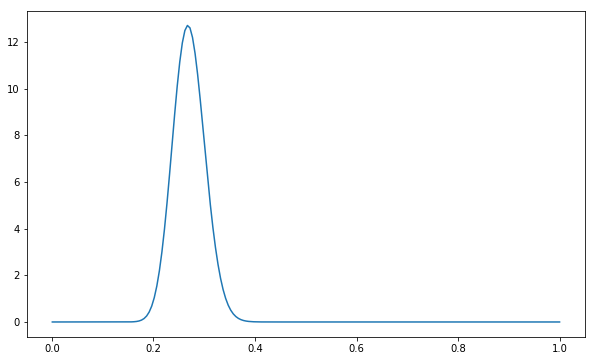

In [38]:
beta_dist = scipy.stats.beta(alpha - 1 + np.sum(x), beta - 1 + np.sum(n - x))

fig, ax = plt.subplots(figsize=(10,6))
xx = np.linspace(0.001, 0.999, 200)
y = [beta_dist.pdf(t) for t in xx]
ax.plot(xx, y)
None

# Rejection sampling

In [70]:
def log_likelihood(p):
    if p <= 0 or p >= 1:
        return -np.inf
    li = (alpha - 1 + np.sum(x)) * np.log(p) + (beta - 1 + np.sum(n-x)) * np.log(1-p)
    li -= np.sum(scipy.special.loggamma(x+1)).real
    li -= np.sum(scipy.special.loggamma(n-x+1)).real
    return li

1.5993604712321174e-147

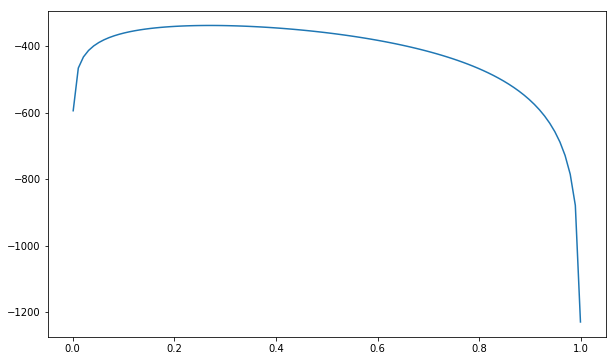

In [43]:
fig, ax = plt.subplots(figsize=(10,6))

xx = np.linspace(0.001, 0.999, 100)
y = [log_likelihood(t) for t in xx]
ax.plot(xx, y)

max_log_y = np.exp(np.max(y)) * 1.1
max_log_y

In [52]:
def sample():
    while True:
        p = np.random.random()
        accept = np.random.random() * max_log_y
        if np.log(accept) <= log_likelihood(p):
            return p

sample()

0.25748283755702606

In [60]:
samples = [sample() for _ in range(10000)]

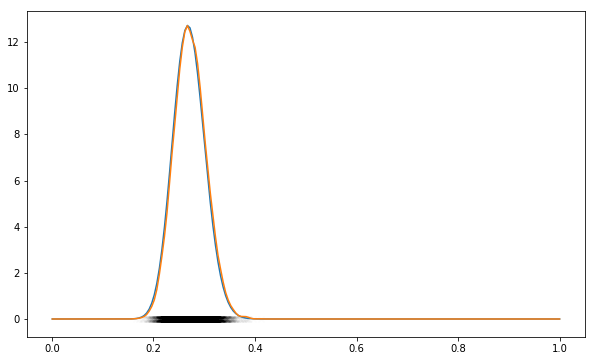

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
xx = np.linspace(0.001, 0.999, 200)
y = [beta_dist.pdf(t) for t in xx]
ax.plot(xx, y)

ax.scatter(samples, [0]*len(samples), marker="x", color="black", alpha=0.01)

ker = scipy.stats.kde.gaussian_kde(samples)
ax.plot(xx, ker(xx))

# With `emcee`

Pure python, so install with

     pip install emcee

In [62]:
import emcee

In [105]:
nwalkers = 10
p0 = np.random.rand(1 * nwalkers).reshape((nwalkers, 1))

In [115]:
sampler = emcee.EnsembleSampler(nwalkers, 1, log_likelihood, args=())

In [116]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [117]:
_ = sampler.run_mcmc(pos, 2000)

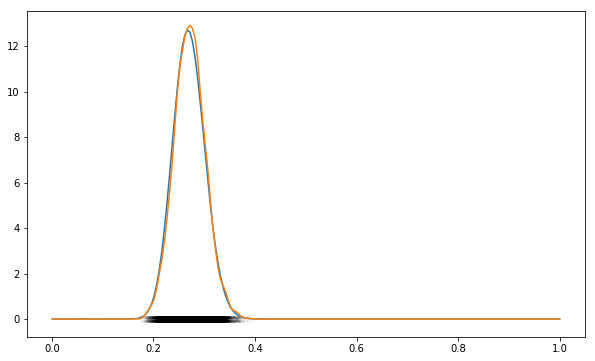

In [118]:
samples = sampler.flatchain[:,0]

fig, ax = plt.subplots(figsize=(10,6))
xx = np.linspace(0.001, 0.999, 200)
y = [beta_dist.pdf(t) for t in xx]
ax.plot(xx, y)

ax.scatter(samples, [0]*len(samples), marker="x", color="black", alpha=0.01)

ker = scipy.stats.kde.gaussian_kde(samples)
ax.plot(xx, ker(xx))

In [119]:
samples.shape

(20000,)

In [120]:
np.mean(sampler.acceptance_fraction)

0.81189999999999996